In [2]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
import math

In [3]:
from trnasimtools.serialize import SerializeTwoCodonMultiTranscript
import os

In [4]:
def read_sim(path_pref, seed_start=1, seed_end=3, seed_incr=1, time_limit=None):
    """ 
    Reads in output for an arbitrary number of simulation trials 
    (with different seeds) and concatenates results into a single
    dataset.
    """
    df_master = pd.read_csv(f"{path_pref}_{seed_start}.tsv", sep="\t")
    df_master["seed"] = str(seed_start)
    for i in range(seed_start+1, seed_end+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    if time_limit is not None:
        df_master = df_master[df_master.time < time_limit]
    return df_master

from bisect import bisect_left
def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before
    
def concat_sims(path_pref, max_seed):
    df_master = pd.read_csv(f"{path_pref}_1.tsv", sep="\t")
    df_master["seed"] = str(1)
    for i in range(2, max_seed+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    
    return df_master
    
def get_average_protein(path, perc_good, time, max_seed):
    df_master = concat_sims(path, max_seed)
    
    df_master["time"] = df_master["time"].apply(np.ceil)
    #tmp = df_master.loc[df_master['time'] == time].groupby(["species"])["protein"].mean().reset_index()
    tmp = df_master.groupby(["time", "species"])["protein", "ribo_density"].mean().reset_index()
    # look at simulations after equilibrium is reached
    tmp = tmp[(tmp.time > time - 50)] 
    tmp["ribo_density_ave"] = tmp[(tmp.species == "cellularProtein")]['ribo_density'].mean()
    tmp = tmp[(tmp.time == time)]
    return tmp

In [6]:
# simulation parameters 
time_limit = 100
time_step = 5
transcript_lens = [1000, 300]
cellular_transcript_copy_number = 100
gfp_transcript_copy_numbers = [5, 10, 15, 20, 50]
ribosome_copy_number = 500
total_trna = 2500
ecol_rbs_rate = 100000.0
ribosome_binding_rates = [10000.0, 30000.0, 100000.0, 300000.0, 1000000.0, 3000000.0]
trna_charging_rates = [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0, 10000.0]
transcript_names = ["cellularProtein", "GFP"]
trna_composition = [(0.7, 0.3)]
ecol_mrna_composition = (0.7, 0.3) 
gfp_mrna_compositions = [(0.9, 0.1), (0.7, 0.3), (0.5, 0.5), (0.3, 0.7), (0.1, 0.9)]
ribosome_footprint = 15

ribosome_speed = 0.5
date = "may-17-2024"

In [ ]:
!mkdir ../yaml/may-17-2024
!mkdir ../output/may-17-2024

In [7]:
for trna_prop in trna_composition:
    for comp in gfp_mrna_compositions:
        serializer = SerializeTwoCodonMultiTranscript(transcript_lens=transcript_lens,
                                                       codon_comps=[ecol_mrna_composition, comp],
                                                       trna_proportion=trna_prop,
                                                       transcript_names=transcript_names,
                                                       time_limit=time_limit,
                                                       time_step=time_step)
        serializer.serialize(f"../yaml/{date}")

configs = os.listdir(f"../yaml/{date}")
with open(f"../scripts/cmd_files/{date}", "w") as stream:
    for config in configs:
        for copy_number in gfp_transcript_copy_numbers:
            for binding_rate in ribosome_binding_rates:
                for charging_rate in trna_charging_rates:
                    for seed in range(1, 4):
                        cmd = f"python3 twocodonmultitranscript.py ../yaml/{date}/{config} {seed} {cellular_transcript_copy_number} {copy_number} " + \
                          f"{ribosome_copy_number} {total_trna} {ecol_rbs_rate} {binding_rate} {charging_rate} {charging_rate} " + \
                          f"../output/{date} {ribosome_speed} {ribosome_footprint}"
                        stream.write(cmd)
                        stream.write("\n")

In [8]:
#gfp_mrna_compositions = [(0.9, 0.1), (0.7, 0.3), (0.5, 0.5), (0.3, 0.7), (0.1, 0.9)]
gfp_mrna_compositions = [(0.9, 0.1), (0.7, 0.3), (0.5, 0.5), (0.1, 0.9)]
df_master = None

for copy_num in gfp_transcript_copy_numbers:
    df_speed = None
    for charging_rate in trna_charging_rates:
        df_charge = None
        for binding_rate in ribosome_binding_rates:
            df_binding = None
            for codons in gfp_mrna_compositions:
                path = f"../output/{date}/two_codon_multi_transcript_0.7_0.3_{codons[0]}_{codons[1]}_0.7_0.3" + \
                       f"_{cellular_transcript_copy_number}_{copy_num}_{ribosome_copy_number}_{total_trna}" + \
                       f"_{ecol_rbs_rate}_{binding_rate}_{charging_rate}_{charging_rate}"
                tmp = get_average_protein(path, 0.5, 100, 3)
                tmp["codon"] = float(codons[0])
                tmp["species"] = tmp["species"].replace({"__ribosome": "free ribosome"})
                if df_binding is not None:
                    df_binding = df_binding.append(tmp, ignore_index=True)
                else:
                    df_binding = tmp
            df_binding["gfp_rbs"] = binding_rate
            if df_charge is not None:
                df_charge = df_charge.append(df_binding, ignore_index=True)
            else:
                df_charge = df_binding
        df_charge["charging_rate"] = charging_rate
        if df_speed is not None:
            df_speed = df_speed.append(df_charge, ignore_index=True)
        else:
            df_speed = df_charge
    df_speed["copy_number"] = copy_num
    if df_master is not None:
        df_master = df_master.append(df_speed, ignore_index=True)
    else:
        df_master = df_speed
    

df_master = df_master[(df_master.time == 100.0)]
df_master["codon"] = df_master["codon"].div(1).round(1)

/tmp/ipykernel_1147422/3640019180.py:51: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tmp = df_master.groupby(["time", "species"])["protein", "ribo_density"].mean().reset_index()


In [10]:
df_master

,time,species,protein,ribo_density,ribo_density_ave,codon,gfp_rbs,charging_rate,copy_number
0,100.0,ATA_charged,45.333333,0.000000,4.899000,0.9,10000.0,10.0,5
1,100.0,ATA_uncharged,704.666667,0.000000,4.899000,0.9,10000.0,10.0,5
2,100.0,GFP,1.333333,0.000000,4.899000,0.9,10000.0,10.0,5
3,100.0,TTT_charged,199.333333,0.000000,4.899000,0.9,10000.0,10.0,5
4,100.0,TTT_uncharged,1550.666667,0.000000,4.899000,0.9,10000.0,10.0,5
...,...,...,...,...,...,...,...,...,...
7555,100.0,TTT_uncharged,6.333333,0.000000,1.128333,0.1,3000000.0,10000.0,50
7556,100.0,__GFP_rbs,44.333333,0.000000,1.128333,0.1,3000000.0,10000.0,50
7557,100.0,__cellularProtein_rbs,100.000000,0.000000,1.128333,0.1,3000000.0,10000.0,50
7558,100.0,free ribosome,31.000000,0.000000,1.128333,0.1,3000000.0,10000.0,50


In [15]:
df_master["gfp_rbs_foldx"] = df_master["gfp_rbs"] / ecol_rbs_rate
#df = df[(df.species == "cellularProtein") | (df.species == "GFP")]
df = df_master.pivot_table(index=['gfp_rbs_foldx', 'codon', 'charging_rate', "copy_number"], columns='species', values='protein').reset_index()

df["TTT_charged_perc"] = df["TTT_charged"] / (total_trna*0.7)
df["ATA_charged_perc"] = df["ATA_charged"] / (total_trna*0.3)
df["free_ribosome_perc"] = df["free ribosome"] / ribosome_copy_number

df['cellularProtein_max'] = df.groupby(['codon', 'charging_rate', "copy_number"])['cellularProtein'].transform('max')
df['cellularProtein_norm'] = df['cellularProtein']/df["cellularProtein_max"]
df['GFP_fraction_total'] = df['GFP'] / (df['cellularProtein'] + df['GFP'])

#df['ATA_charged_max'] = df.groupby(['codon', 'charging_rate', "speed"])['ATA_charged'].transform('max')
#df['ATA_charged_norm'] = df['ATA_charged']/df["ATA_charged_max"]
#df['TTT_charged_max'] = df.groupby(['codon', 'charging_rate', "speed"])['TTT_charged'].transform('max')
#df['TTT_charged_norm'] = df['TTT_charged']/df["TTT_charged_max"]

df = df.rename_axis("index", axis=1).reset_index(drop=True)
df

index,gfp_rbs_foldx,codon,charging_rate,copy_number,ATA_charged,ATA_uncharged,GFP,TTT_charged,TTT_uncharged,__GFP_rbs,__cellularProtein_rbs,cellularProtein,free ribosome,TTT_charged_perc,ATA_charged_perc,free_ribosome_perc,cellularProtein_max,cellularProtein_norm,GFP_fraction_total
0,0.1,0.1,10.0,5,41.333333,708.666667,1.666667,221.666667,1528.333333,5.000000,100.000000,2004.333333,1.666667,0.126667,0.055111,0.003333,2004.333333,1.000000,0.000831
1,0.1,0.1,10.0,10,39.333333,710.666667,4.666667,186.666667,1563.333333,10.000000,100.000000,2000.333333,1.000000,0.106667,0.052444,0.002000,2002.000000,0.999167,0.002328
2,0.1,0.1,10.0,15,37.333333,712.666667,6.666667,221.666667,1528.333333,15.000000,99.666667,2001.333333,1.666667,0.126667,0.049778,0.003333,2001.333333,1.000000,0.003320
3,0.1,0.1,10.0,20,43.333333,706.666667,10.000000,189.333333,1560.666667,20.000000,99.333333,2002.666667,1.666667,0.108190,0.057778,0.003333,2002.666667,1.000000,0.004969
4,0.1,0.1,10.0,50,41.000000,709.000000,63.333333,197.000000,1553.000000,50.000000,99.000000,1980.000000,2.333333,0.112571,0.054667,0.004667,1980.000000,1.000000,0.030995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,30.0,0.9,10000.0,5,742.000000,8.000000,1712.000000,1735.333333,14.666667,5.000000,97.333333,23039.333333,120.000000,0.991619,0.989333,0.240000,23352.333333,0.986597,0.069168
836,30.0,0.9,10000.0,10,744.000000,6.000000,6384.000000,1730.333333,19.666667,9.333333,98.000000,22202.333333,115.000000,0.988762,0.992000,0.230000,23353.000000,0.950727,0.223323
837,30.0,0.9,10000.0,15,743.000000,7.000000,13365.000000,1733.000000,17.000000,13.666667,99.666667,20904.000000,106.333333,0.990286,0.990667,0.212667,23356.666667,0.894991,0.390003
838,30.0,0.9,10000.0,20,745.000000,5.000000,21777.333333,1733.000000,17.000000,17.333333,98.333333,19277.666667,94.333333,0.990286,0.993333,0.188667,23351.333333,0.825549,0.530443


(10000.0, 13246.533333333335)

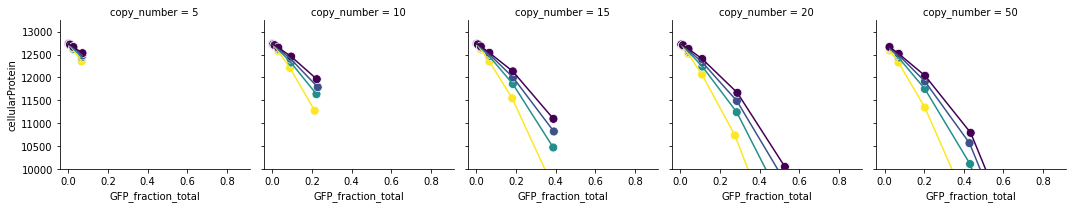

In [43]:
df_copy_num = df[(df.charging_rate == 100)]
#g = sns.FacetGrid(df, col="charging_rate", row="copy_number")
g = sns.FacetGrid(df_copy_num, col="copy_number")
g.map_dataframe(sns.scatterplot, x="GFP_fraction_total", y="cellularProtein", hue = "codon", s=80, palette="viridis_r")
g.map_dataframe(sns.lineplot, x="GFP_fraction_total", y="cellularProtein", hue = "codon", palette="viridis_r")
#plt.xlim(0, 10000)
plt.ylim(10000)

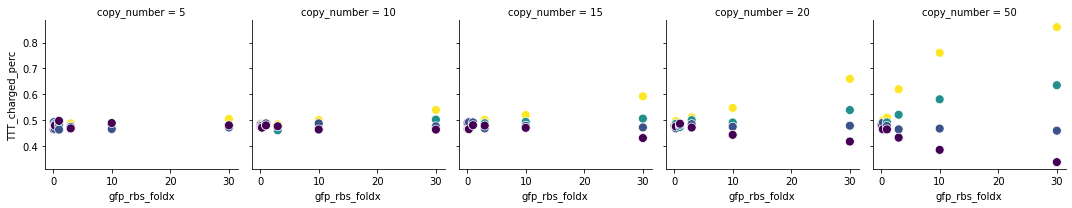

In [46]:
df_copy_num = df[(df.charging_rate == 100)]
#g = sns.FacetGrid(df, col="charging_rate", row="copy_number")
g = sns.FacetGrid(df_copy_num, col="copy_number")
g.map_dataframe(sns.scatterplot, x="gfp_rbs_foldx", y="TTT_charged_perc", hue = "codon", s=80, palette="viridis_r")
#g.map_dataframe(sns.lineplot, x="", y="cellularProtein", hue = "codon", palette="viridis_r")
#plt.xlim(0, 10000)
#plt.ylim(10000)

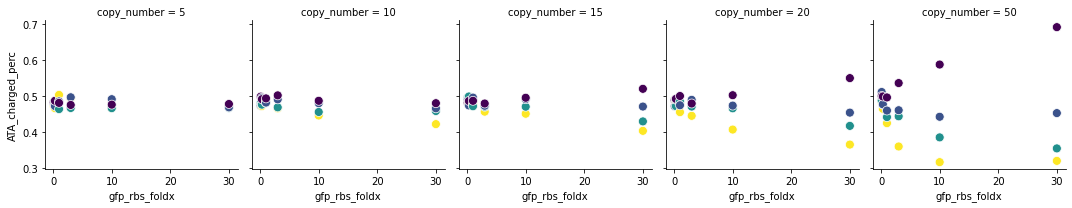

In [47]:
df_copy_num = df[(df.charging_rate == 100)]
#g = sns.FacetGrid(df, col="charging_rate", row="copy_number")
g = sns.FacetGrid(df_copy_num, col="copy_number")
g.map_dataframe(sns.scatterplot, x="gfp_rbs_foldx", y="ATA_charged_perc", hue = "codon", s=80, palette="viridis_r")
#g.map_dataframe(sns.lineplot, x="", y="cellularProtein", hue = "codon", palette="viridis_r")
#plt.xlim(0, 10000)
#plt.ylim(10000)

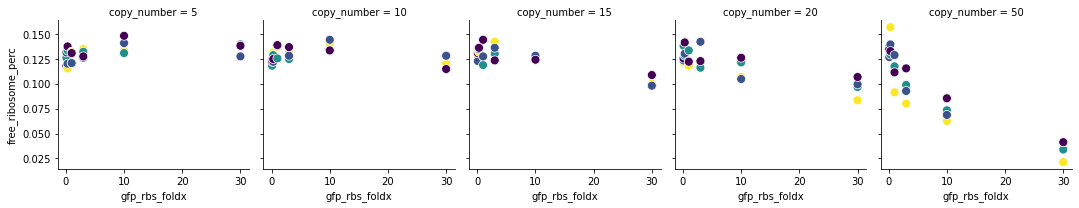

In [48]:
df_copy_num = df[(df.charging_rate == 100)]
#g = sns.FacetGrid(df, col="charging_rate", row="copy_number")
g = sns.FacetGrid(df_copy_num, col="copy_number")
g.map_dataframe(sns.scatterplot, x="gfp_rbs_foldx", y="free_ribosome_perc", hue = "codon", s=80, palette="viridis_r")
#g.map_dataframe(sns.lineplot, x="", y="cellularProtein", hue = "codon", palette="viridis_r")
#plt.xlim(0, 10000)
#plt.ylim(10000)